In [1]:
import tensorflow as tf
import numpy as np
import utils
import random

In [2]:
text = utils.load_text()
words = utils.preprocess(text)
print(len(words))
print(words[:10])
vocab_to_int, int_to_vocab = utils.create_lookup_tabels(words)
int_words = [vocab_to_int[word] for word in words]
int_words = utils.subsampling(int_words)

Replace punctuation with tokens ......
Remove all words with  5 or fewer occurences ......
16680599
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']
Subsampling ......


In [3]:
len(vocab_to_int)

63641

In [4]:
inputs_ = tf.placeholder(dtype=tf.int32, shape=[None], name="inputs_")
labels_ = tf.placeholder(dtype=tf.int32, shape=[None,None], name="labels_")
step = tf.Variable(0,dtype=tf.int32,name="global_step")

n_vocab = len(vocab_to_int)
n_embedding = 200
embedding = tf.Variable(tf.random_uniform([n_vocab, n_embedding],-1,1), name="embedding")
embed = tf.nn.embedding_lookup(embedding, inputs_, name="embed")

weight = tf.Variable(tf.truncated_normal([n_vocab, n_embedding], stddev=0.1), name="weight")
# This is because in tf.nn.sampled_softmax_loss() function:
# logits = tf.matmul(inputs, tf.transpose(weights))
bias = tf.Variable(tf.zeros(n_vocab), name="bias")

# Negative sampling
num_sampled = 100
cost = tf.nn.sampled_softmax_loss(weight, bias, labels_, embed, num_sampled=num_sampled, num_classes=n_vocab)
cost = tf.reduce_mean(cost, name="cost")

optimizer = tf.train.AdamOptimizer().minimize(cost,global_step=step, name="opt")

saver = tf.train.Saver()

In [5]:
## From Thushan Ganegedara's implementation
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100
# pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
valid_examples = np.append(valid_examples, random.sample(range(1000, 1000+valid_window), valid_size//2))

valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
normalized_embedding = embedding / norm
valid_embed = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
similarity = tf.matmul(valid_embed, tf.transpose(normalized_embedding), name="similarity")


In [6]:
!mkdir checkpoints

子目录或文件 checkpoints 已经存在。


In [8]:
epochs = 10
batch_size = 1000
window_size = 10
global_step = 0

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
        for x, y in utils.get_batches(int_words, batch_size, window_size):
            c, global_step, _ = sess.run([cost,step,optimizer], 
                                         feed_dict={inputs_:np.array(x), labels_:np.array(y)[:,None]})
            if global_step % 100 ==1:
                print("Epoch {}, Iteration {}: cost {:.5f}".format(e+1, global_step, c))
            
            if global_step % 1000 ==0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
    saver.save(sess, "checkpoints/text8.ckpt")

Epoch 1, Iteration 1: cost 5.42764
Epoch 1, Iteration 101: cost 5.50034
Epoch 1, Iteration 201: cost 5.22910
Epoch 1, Iteration 301: cost 5.46652
Epoch 1, Iteration 401: cost 5.53846
Epoch 1, Iteration 501: cost 5.71637
Epoch 1, Iteration 601: cost 5.63522
Epoch 1, Iteration 701: cost 5.33036
Epoch 1, Iteration 801: cost 5.40107
Epoch 1, Iteration 901: cost 5.87537
Nearest to between: associative, evoking, mascarenes, lifestyle, bowed, pw, detected, munroe,
Nearest to where: per, questionable, nesting, married, doctoral, unforgettable, positively, angell,
Nearest to th: bautista, hull, balls, lucasarts, alyattes, exiles, aboriginal, merian,
Nearest to would: jacket, mcleod, cipm, cara, gil, mahendra, thai, luckily,
Nearest to of: eurovision, mason, stf, consolamentum, termite, enya, collective, looked,
Nearest to to: reckoned, gosh, skeet, maury, trafalgar, qualification, capitalism, campomanes,
Nearest to their: aage, favour, antiarrhythmic, grazed, whitbread, organelles, strategist, 

In [9]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from checkpoints\text8.ckpt


In [11]:
print(embed_mat.shape)

(63641, 200)


In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [13]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

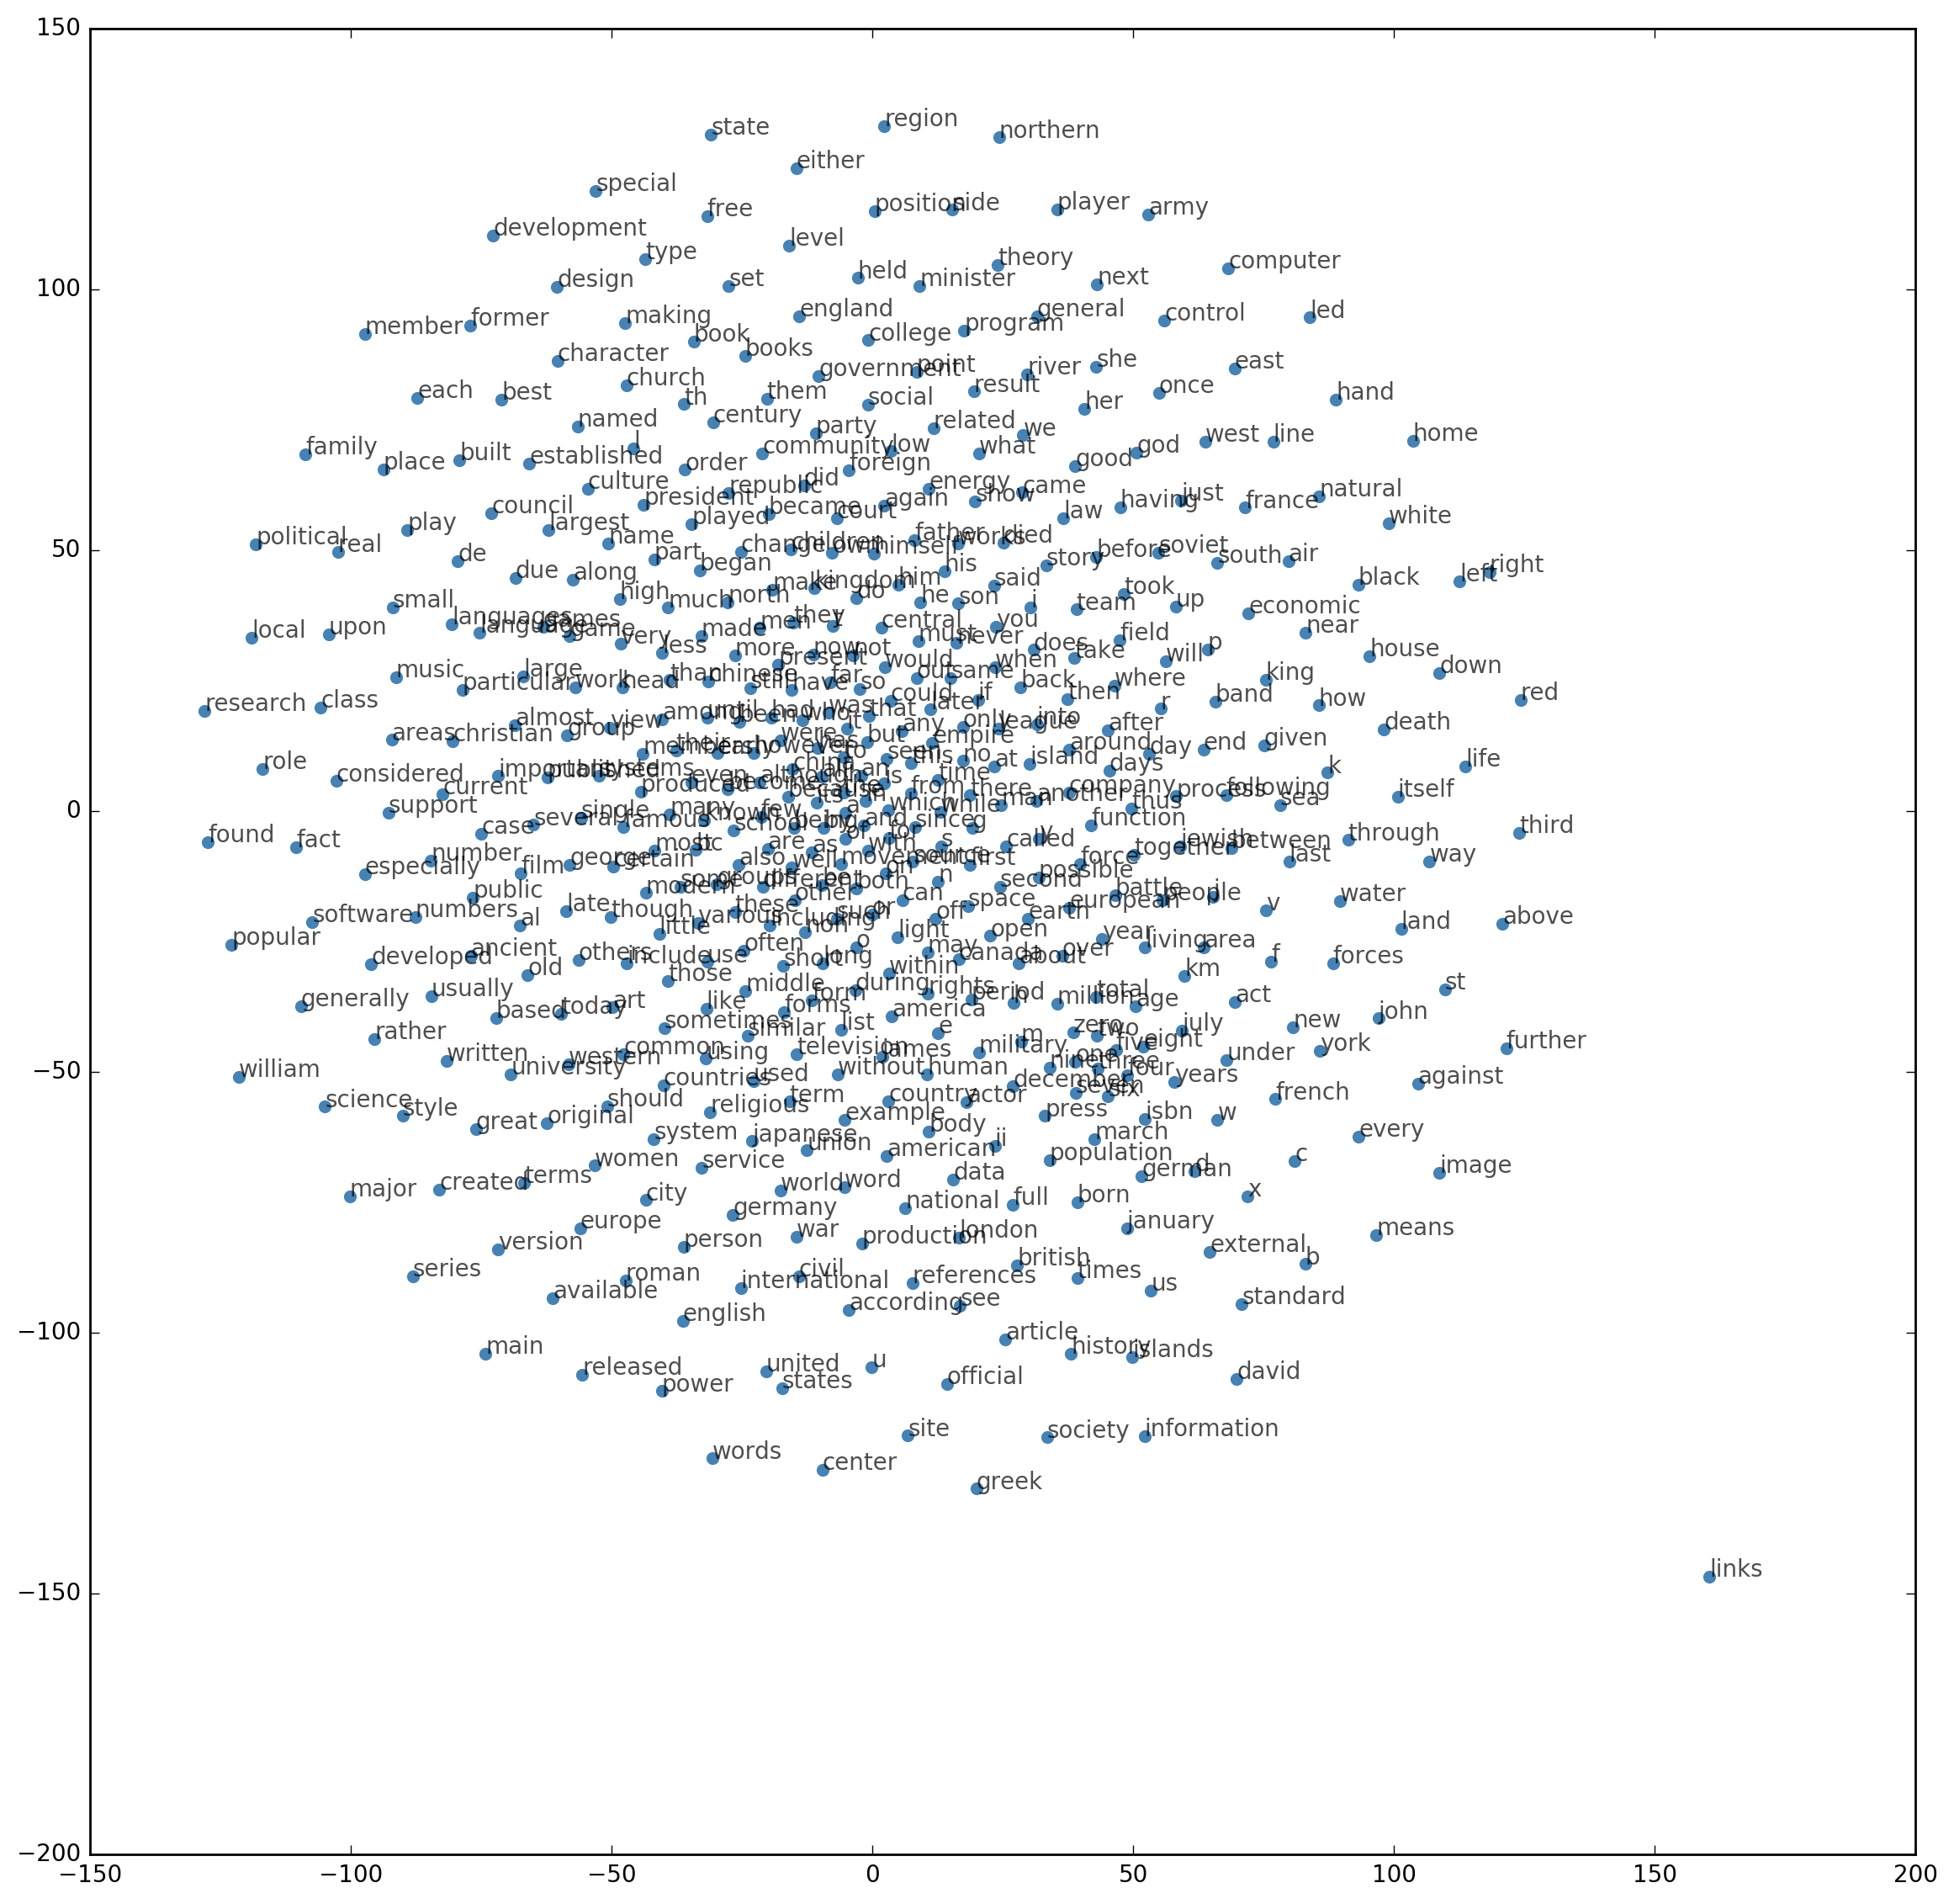

In [15]:
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [19]:
import pickle
with open('data/word2vec.p','wb') as f:
    save ={'int_to_vocab':int_to_vocab, 'vocab_to_int':vocab_to_int, 'embed_mat':embed_mat}
    pickle.dump(save, f)

In [20]:
with open('data/word2vec.p','rb') as f:
    save=pickle.load(f)
    print(save.keys())

dict_keys(['int_to_vocab', 'vocab_to_int', 'embed_mat'])
